# Disentangled RNNs
This is a test file to understand what is going on in Disentangled RNNs.

In [2]:
from disentangled_rnns.library import get_datasets
from disentangled_rnns.library import two_armed_bandits
from disentangled_rnns.library import rnn_utils
from disentangled_rnns.library import disrnn
import optax

# Synthetic dataset from a q-learning agent. See other options above.
agent = two_armed_bandits.AgentQ(alpha=0.3, beta=3)
environment = two_armed_bandits.EnvironmentBanditsDrift(sigma=0.1)
dataset = two_armed_bandits.create_dataset(
    agent,
    environment,
    n_steps_per_session=200,
    n_sessions=1000,
    batch_size=1000,
    plot=True
)

update_mlp_shape = (5,5,5)
choice_mlp_shape = (2,2)
latent_size = 5
beta_scale = 0.1

def make_network():
  return disrnn.HkDisRNN(update_mlp_shape=update_mlp_shape,
                        choice_mlp_shape=choice_mlp_shape,
                        latent_size=latent_size,
                        obs_size=2, target_size=2,
                        beta_scale=beta_scale)

learning_rate = 1e-3
opt = optax.adam(learning_rate)

In [3]:
print(dir(dataset))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__next__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_batch_size', '_dataset_size', '_idx', '_xs', '_ys', 'n_batches']


Step 1000 of 1000. Training Loss: 1.09e+05. Validation Loss: 1.09e+05


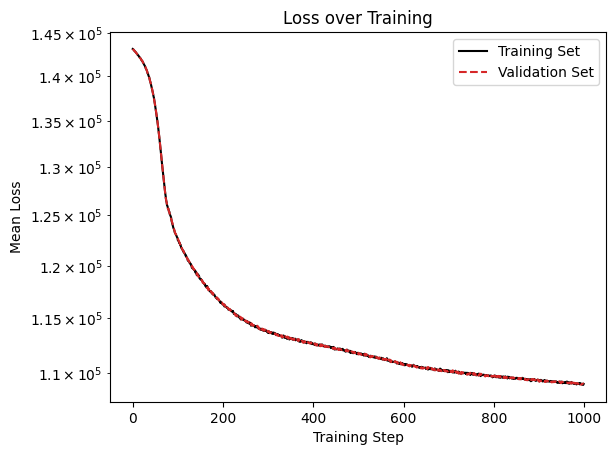

In [2]:
# Train one step to initialize
params, opt_state, losses = rnn_utils.train_network(
   make_network,
    dataset,
    dataset,
    opt = optax.adam(1e-2),
    loss="penalized_categorical",
    n_steps=0)

# Train additional steps
n_steps = 1000
params, opt_state, losses = rnn_utils.train_network(
make_network,
    dataset,
    dataset,
    loss="penalized_categorical",
    params=params,
    opt_state=opt_state,
    opt = optax.adam(1e-3),
    penalty_scale = 1,
    n_steps=n_steps,
    do_plot = True)

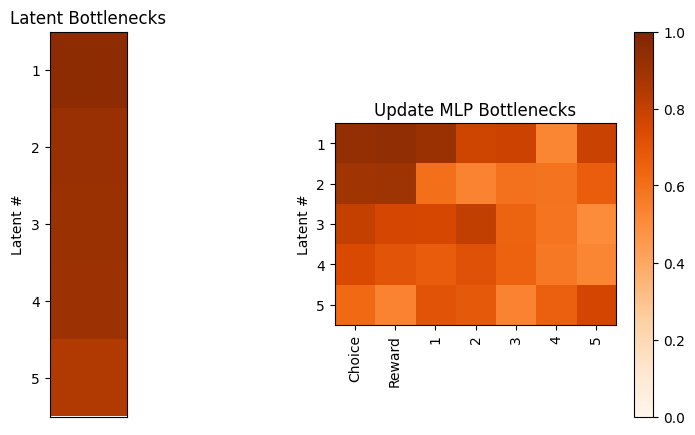

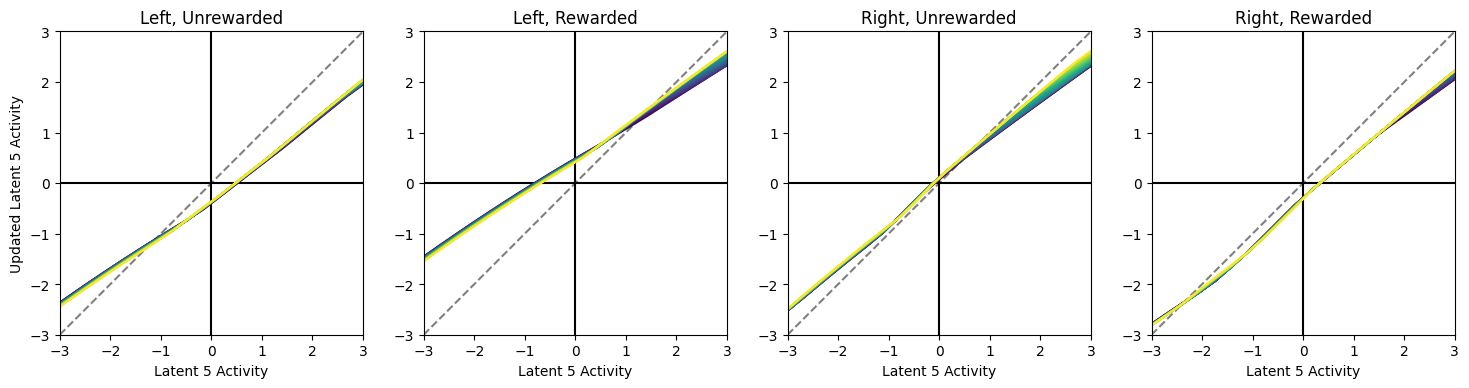

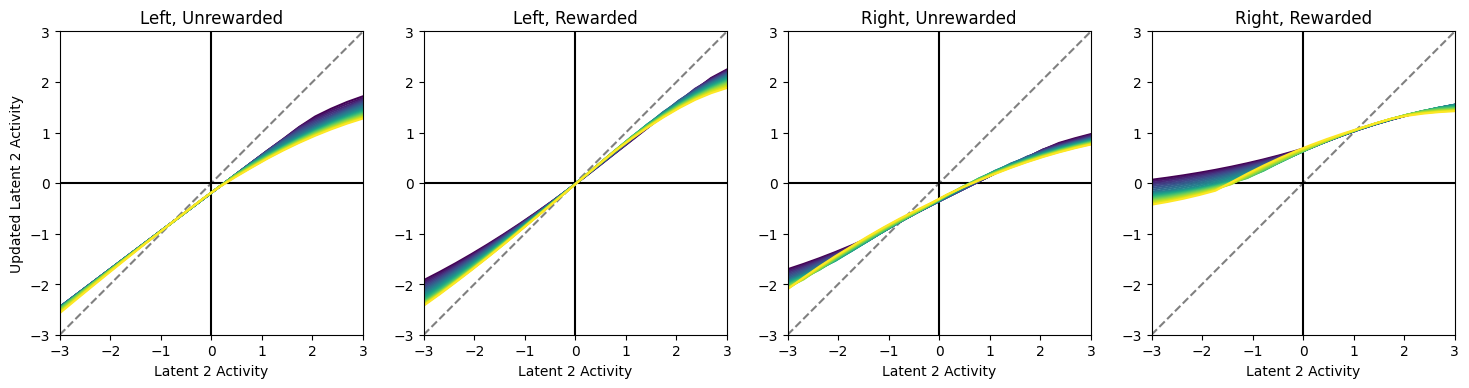

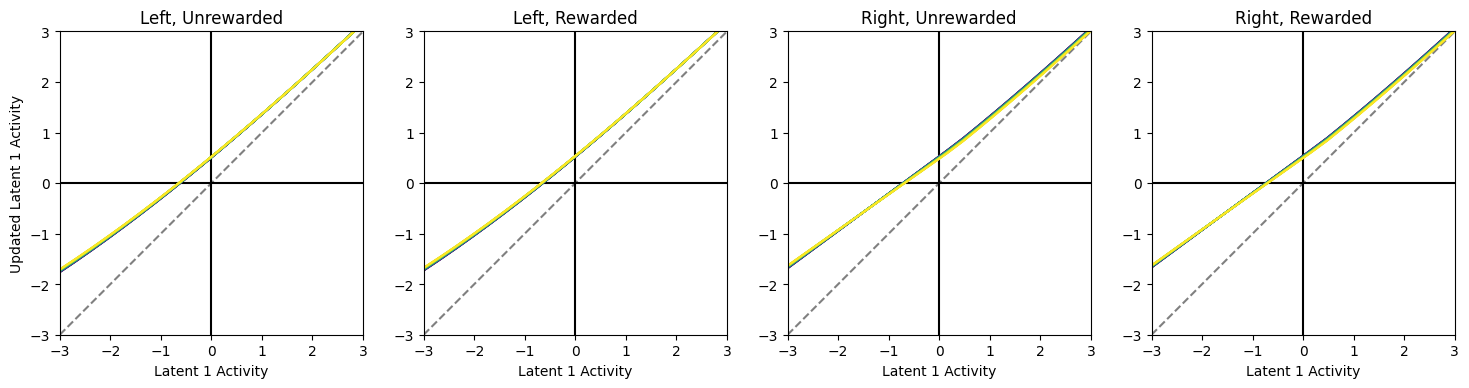

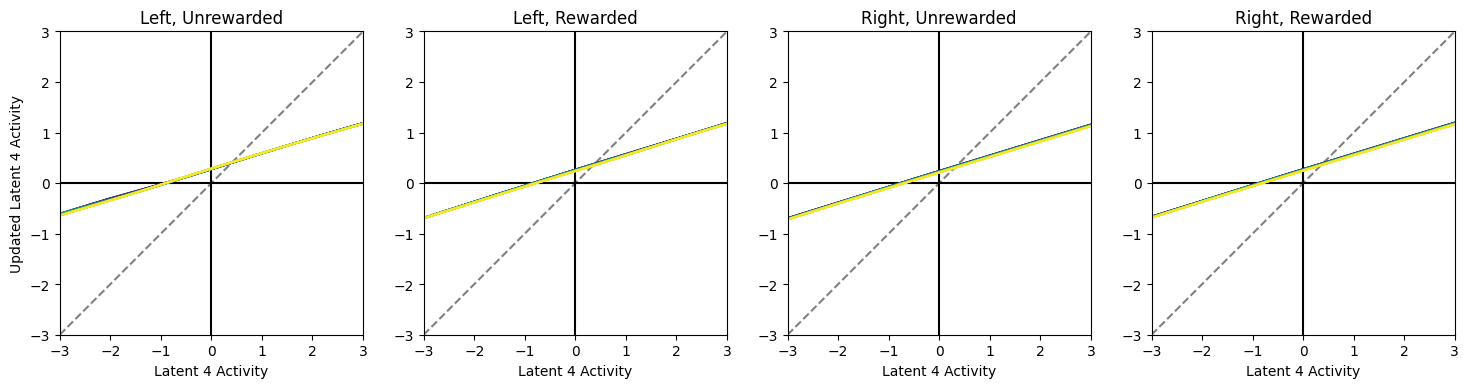

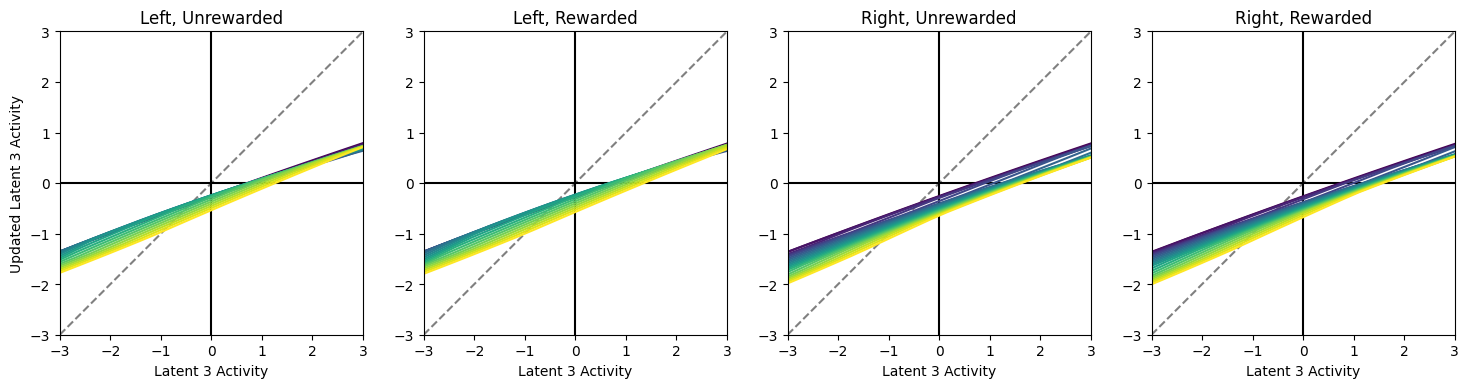

In [4]:
from matplotlib import pyplot as plt

# Eval mode runs the network with no noise
def make_network_eval():
  return disrnn.HkDisRNN(update_mlp_shape=update_mlp_shape,
                        choice_mlp_shape=choice_mlp_shape,
                        latent_size=latent_size,
                        obs_size=2, target_size=2,
                        eval_mode=True)


disrnn.plot_bottlenecks(params, make_network_eval)
plt.show()
disrnn.plot_update_rules(params, make_network_eval)
plt.show()

In [ ]:
xs, ys = next(dataset)
_ , network_states = rnn_utils.eval_network(make_network_eval, params, xs)